## Setup

```
pipenv install geopandas
pipenv install descartes
pipenv install matplotlib
```

## Resources

* [SF police incidents data](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783) and [data dictionary for the police incidents](https://bit.ly/2x7Ta2P)
* [SF neighborhoods geospatial files](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h)
* [SF school locations](https://data.sfgov.org/Economy-and-Community/Map-of-Schools/qb37-w9se)
* [geopandas](http://geopandas.org/index.html)

## To Do

* Data vetting
  * Check for blank/null neighborhoods in drunkenness.csc
  * Check that no neighnborhoods are dropped on join
  * Check that neighborhood names match precisely in both data sets

In [32]:
#from datetime import datetime as dt
import geopandas
import pandas as pd

pd.options.display.max_rows = None


%matplotlib inline

In [33]:
shapes = geopandas.read_file('zip://data/Analysis Neighborhoods.zip')

In [34]:
shapes.head(3)

,nhood,geometry
0,Bayview Hunters Point,POLYGON ((-122.3815777424142 37.75307043091241...
1,Bernal Heights,"POLYGON ((-122.403612999828 37.74933700015653,..."
2,Castro/Upper Market,POLYGON ((-122.4265550005568 37.76948499984702...


In [35]:
# Note we use the parse_dates parameter to convert the 
# date field values to datetime objects
local_file = 'data/drunkenness.csv'
incidents = pd.read_csv(local_file, parse_dates=['incident_date', 'incident_datetime'])
# Make columns snake_case to simplify downstream code
incidents.columns = [col.lower().replace(' ', '_') for col in incidents.columns]

In [36]:
incidents = incidents.rename(index=str, columns={'analysis_neighborhood': 'nhood'})

In [161]:
nhood_counts = incidents.groupby(by='nhood').row_id.count().reset_index()
nhood_counts2 = incidents.groupby(by='nhood').nhood.value_counts()

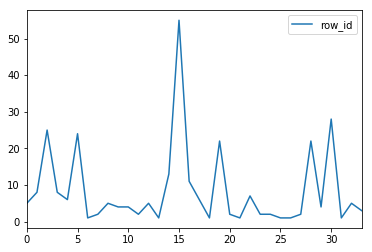

In [162]:
nhood_counts.plot()

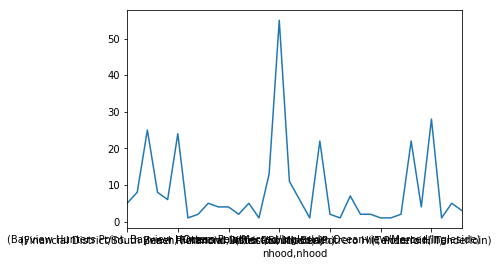

In [163]:
nhood_counts2.plot()

In [150]:
nhood_counts.head()

nhood
Bayview Hunters Point     5
Bernal Heights            8
Castro/Upper Market      25
Chinatown                 8
Excelsior                 6
Name: row_id, dtype: int64

In [38]:
nhood_counts.count()

nhood     34
row_id    34
dtype: int64

In [39]:
shapes['nhood']

0              Bayview Hunters Point
1                     Bernal Heights
2                Castro/Upper Market
3                          Chinatown
4                          Excelsior
5     Financial District/South Beach
6                          Glen Park
7                     Inner Richmond
8                   Golden Gate Park
9                     Haight Ashbury
10                      Hayes Valley
11                      Inner Sunset
12                         Japantown
13                      McLaren Park
14                        Tenderloin
15                         Lakeshore
16                      Lincoln Park
17                 Lone Mountain/USF
18                            Marina
19                      Russian Hill
20                           Mission
21                       Mission Bay
22                          Nob Hill
23                          Seacliff
24                        Noe Valley
25                       North Beach
26        Oceanview/Merced/Ingleside
2

In [40]:
# Left join and set unmatched neighborhoods (i.e. those with no incidents) to zero
merged = shapes.merge(nhood_counts, on='nhood', how='left').fillna(0)

In [41]:
merged.count()

nhood       41
geometry    41
row_id      41
dtype: int64

In [144]:
merged.head()

,nhood,geometry,row_id
0,Bayview Hunters Point,POLYGON ((-122.3815777424142 37.75307043091241...,5.0
1,Bernal Heights,"POLYGON ((-122.403612999828 37.74933700015653,...",8.0
2,Castro/Upper Market,POLYGON ((-122.4265550005568 37.76948499984702...,25.0
3,Chinatown,POLYGON ((-122.4062259995664 37.79755900029376...,8.0
4,Excelsior,POLYGON ((-122.4239820002333 37.73155199975518...,6.0


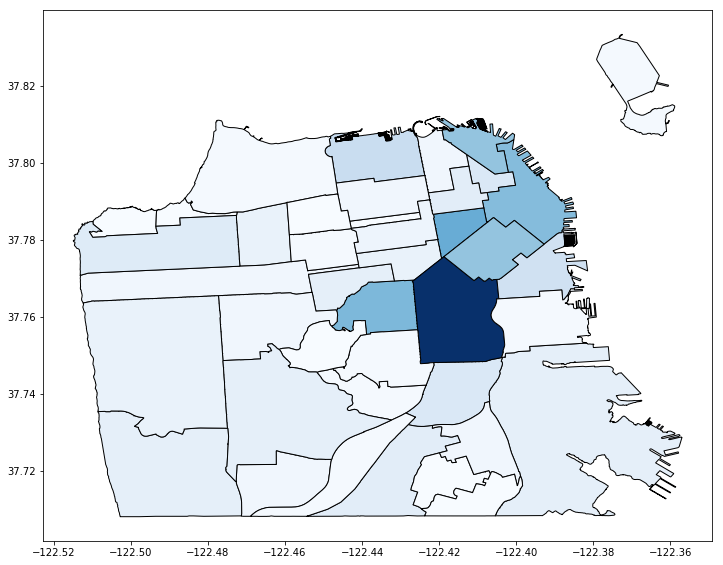

In [130]:
ax_drunk = merged.plot(
    column='row_id',
    cmap='Blues',
    edgecolor='Black',
    figsize=(12, 10)
)

In [131]:
schools = pd.read_csv('data/Map_of_Schools.csv')
schools.rename(columns={col: col.lower().replace(' ', '_') for col in schools.columns}, inplace=True)

In [132]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 16 columns):
campus_name            445 non-null object
ccsf_entity            445 non-null object
lower_grade            445 non-null int64
upper_grade            445 non-null int64
grade_range            445 non-null object
category               445 non-null object
map_label              445 non-null object
lower_age              445 non-null int64
upper_age              445 non-null int64
general_type           445 non-null object
cds_code               445 non-null object
campus_address         445 non-null object
supervisor_district    445 non-null int64
county_fips            445 non-null int64
county_name            445 non-null object
location_1             445 non-null object
dtypes: int64(6), object(10)
memory usage: 55.7+ KB


## Prepare point data

In order to perform geographic operations on the school locations, we'll need to parse and transfrom the string values in `location_1` into Python floats, and then convert the resulting lon/lat pairs into shapely [Point](https://shapely.readthedocs.io/en/stable/manual.html#points) objects.

> See [Creating a GeoDataFrame from a DataFrame with coordinates](http://geopandas.org/gallery/create_geopandas_from_pandas.html#sphx-glr-gallery-create-geopandas-from-pandas-py) for more details/background.

In [133]:
# Here's a sample value from the location_1
schools.location_1[0]

'CA\n(37.7830048, -122.4822998)'

In [134]:
from shapely.geometry import Point
import re

def point_from_str(location):
    lat, lon = map(float, re.findall(r'(-?\d+\.\d+)', location))
    return (lon, lat)

# Create a coordinates column with proper lon/lat tuples
schools['coordinates'] = schools.location_1.apply(coords_from_str)
# Convert to Geopandas Points
schools['coordinates'] = schools['coordinates'].apply(Point)

In [135]:
# Now create the GeoDataFrame
schools_gdf = geopandas.GeoDataFrame(schools, geometry='coordinates')

In [136]:
schools_gdf.head()

,campus_name,ccsf_entity,lower_grade,upper_grade,grade_range,category,map_label,lower_age,upper_age,general_type,cds_code,campus_address,supervisor_district,county_fips,county_name,location_1,coordinates
0,Alamo Elementary School,SFUSD,0,5,K-5,USD Grades K-5,PS001,5,10,PS,38684786040695,"250 23RD AVE, San Francisco, CA 94121",1,6075,SAN FRANCISCO,"CA\n(37.7830048, -122.4822998)",POINT (-122.4822998 37.7830048)
1,Alvarado Elementary School,SFUSD,0,5,K-5,USD Grades K-5,PS002,5,10,PS,38684786040703,"625 DOUGLASS ST, San Francisco, CA 94114",8,6075,SAN FRANCISCO,"CA\n(37.7536812, -122.4381943)",POINT (-122.4381943 37.7536812)
2,Aptos Middle School,SFUSD,6,8,6-8,USD Grades 6-8,PS003,11,13,PS,38684786062020,"105 APTOS AVE, San Francisco, CA 94127",7,6075,SAN FRANCISCO,"CA\n(37.7296715, -122.4657822)",POINT (-122.4657822 37.7296715)
3,Argonne Early Education School,SFUSD,-2,0,PK-TK,USD PreK/TK,PS004,3,5,PS,384000981,"750 16TH AVE, San Francisco, CA 94118",1,6075,SAN FRANCISCO,"CA\n(37.7739677, -122.4740601)",POINT (-122.4740601 37.7739677)
4,Argonne Elementary School,SFUSD,0,5,K-5,USD Grades K-5,PS005,5,10,PS,38684786040737,"680 18TH AVE, San Francisco, CA 94121",1,6075,SAN FRANCISCO,"CA\n(37.7753067, -122.4763107)",POINT (-122.4763107 37.7753067)


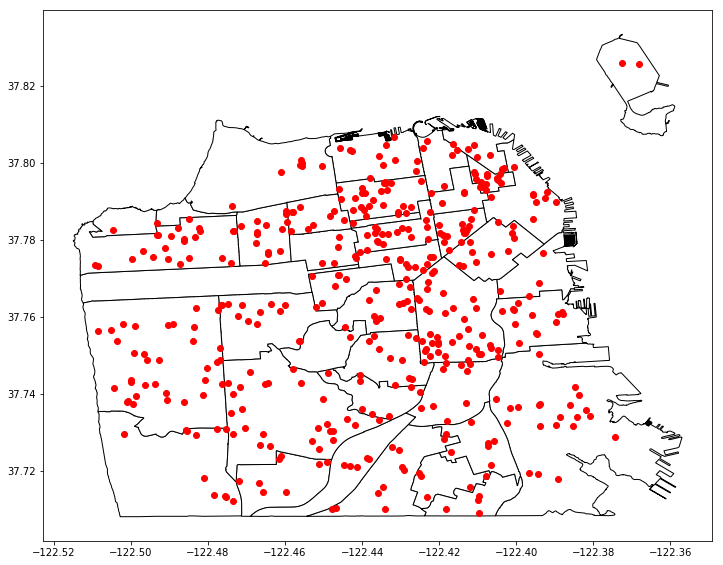

In [164]:
ax = shapes.plot(color='white', edgecolor='black', figsize=(12, 12))
schools_gdf.plot(ax=ax, color='red')

In [138]:
ax_drunk